In [1]:
!pip install einops

  Using cached einops-0.8.1-py3-none-any.whl.metadata (13 kB)
Using cached einops-0.8.1-py3-none-any.whl (64 kB)


In [2]:
%load_ext autoreload
%autoreload 2

import seaborn as sns
from dataclasses import dataclass
import matplotlib.pyplot as plt

import datautils
from utils import init_dl_program
from utils import find_closest_train_segment
from hdst import HDST
import torch
import gc
import numpy as np



# **T-Rep tutorial**

The goal of this tutorial is to show you in depth:

1. How to instantiate T-Rep with the most important parameters.
2. How to train T-Rep.
3. How to use a trained model to encode test data, at different granularities.

This tutorial is more in-depth than the 'quick tutorial', as it aims to explain the parameters of the various functions used.

#### **1. Instantiate ``Args`` Configuration Class**

The ``Args`` class is normally imported from the `train_eval.py` file but it is redefined here with extra comments for clarity.

In [3]:
# @dataclass
# class Args:
#     # MODEL PARAMETERS
#     task_weights: dict # Weights to attribute to each pretext task
#     repr_dims: int = 128 # Latent representation dimensionality
#     time_embedding: str = None # Time embedding to use ('t2v_sin', 'fully_learnable_big', 'gaussian', 'hybrid' etc.), 'None' for no time embedding. All implemented time-embeddings are defined in models.time_embeddings.py

#     # TRAINING PARAMETERS
#     epochs: int = 80 # Maximum number of training epochs
#     iters: int = None # Maximum number of training iterations. Can be set to 'None' if epochs is set.
#     batch_size: int = 16 # Training batch size
#     lr: float = 0.001 # Learning rate
#     seed: int = 1234 # Random seed for reproducibility
#     max_train_length: int = 800 # Maximum sequence length (depends on your GPU memory).
#                            # Longer sequences will be cut into smaller sequences.

#     # CONFIGURATION
#     dataset: str = "" # Set to "" if using your own dataset. If you use UCR/UEA datasets, the dataset name
#     loader: str = "" # Set to "" if using your own dataset, otherwise "UEA" or "UCR"
#     gpu: int = 0 # The gpu no. used for training and inference (defaults to 0)
#     run_name: str = "" # Run name to save model
#     save_every = None # Save the model checkpoint every <save_every> iterations/epochs
#     max_threads = None # The maximum allowed number of threads used by this process. Set to None if unsure.
#     eval: bool = True # Evaluate model after training if True (doesn't work for custom datasets, only UCR/UEA/ETT/Yahoo)
#     irregular: float = 0.0 # Ratio of missing data (defaults to 0). Used for testing model resilience under missing data regime
#     label_ratio: int = 1.0 # Ratio of available training labels (defaults to 1.0). Used for testing model resilience under missing labels regime


In [50]:
@dataclass
class Args:
    task_weights: dict
    dataset: str = ""
    loader: str = ""
    gpu: int = 0
    static_repr_dims: int = 128
    dynamic_repr_dims: int = 128
    epochs: int = 200

    run_name: str = ""
    batch_size: int = 16
    lr: float = 0.001
    max_train_length = 800
    iters: int = None
    save_every = None
    seed: int = 1234
    max_threads = None
    eval: bool = True
    irregular = 0

    sample_size: int = 50
    window_size: int = 20

- Create an instance of arguments, specifying the necessary arguments and those important to your use case.
- Initialise device as well as config dict

In [51]:
args = Args(
    static_repr_dims=128,
    dynamic_repr_dims=128,
    task_weights={
        'local_static_contrast': 0,
        'global_vatiant_contrast': 1,
        'dynamic_trend_pred': 0,
    },
    eval=False,
    batch_size=32,
)

device = init_dl_program(args.gpu, seed=args.seed, max_threads=args.max_threads)

#### **2. Load your data**

You can use any data, as long as it is an `np.ndarray` of shape $(N, T, C)$ where $N$ is the number of time-series instances, $T$ the number of timesteps per instance, and $C$ the number of channels.

Here, we use a UCR dataset as an example, but you can use any dataset of yours.

**N.B:** For the following cell to work, you will have to have downloaded the `UCR` datasets and placed them in the `datasets/UCR/` folder as instructed in the `README.md`

In [52]:
# data, train_slice, valid_slice, test_slice, scaler, pred_lens = datautils.load_forecast_csv("ETTh1")
# train_data = data[:, train_slice]
# test_data = data[:, test_slice]
# print(f"Shapes - train data: {train_data.shape}, test data: {test_data.shape}")

In [53]:
train_data, train_labels, test_data, test_labels = datautils.load_UEA("AtrialFibrillation")
print(f"Shapes - train data: {train_data.shape}, test data: {test_data.shape}")

Shapes - train data: (15, 640, 2), test data: (15, 640, 2)


#### **3. Create and train T-Rep**

In [54]:
sns.set_theme()
torch.cuda.empty_cache()
gc.collect()

951

In [60]:
import time
start_time = time.time()
model = HDST(
    input_dims=train_data.shape[-1],
    device=device,
    task_weights=args.task_weights,
    batch_size=args.batch_size,
    lr=args.lr,
    output_dims1=args.static_repr_dims,
    output_dims2=args.dynamic_repr_dims,
    max_train_length=args.max_train_length
)

loss_log = model.fit(
    train_data,
    n_epochs=args.epochs,
    n_iters=args.iters,
    k=args.sample_size,
    w=args.window_size
)
end_time = time.time()
training_time = end_time - start_time
print(f"Model training time: {training_time:.2f} seconds")

Training data shape: (15, 640, 2)
Epoch #0: loss=4.615279197692871
Epoch #1: loss=4.608858585357666
Epoch #2: loss=4.592249393463135
Epoch #3: loss=4.585547924041748
Epoch #4: loss=4.589338779449463
Epoch #5: loss=4.579836368560791
Epoch #6: loss=4.58328104019165
Epoch #7: loss=4.578164100646973
Epoch #8: loss=4.574679374694824
Epoch #9: loss=4.576905727386475
Epoch #10: loss=4.575772285461426
Epoch #11: loss=4.573581218719482
Epoch #12: loss=4.575310707092285
Epoch #13: loss=4.577034950256348
Epoch #14: loss=4.5701775550842285
Epoch #15: loss=4.570874214172363
Epoch #16: loss=4.57006311416626
Epoch #17: loss=4.571051597595215
Epoch #18: loss=4.572910308837891
Epoch #19: loss=4.571670055389404
Epoch #20: loss=4.565188884735107
Epoch #21: loss=4.56427001953125
Epoch #22: loss=4.569342613220215
Epoch #23: loss=4.563863277435303
Epoch #24: loss=4.5699968338012695
Epoch #25: loss=4.566093921661377
Epoch #26: loss=4.56439733505249
Epoch #27: loss=4.558350086212158
Epoch #28: loss=4.55993938

In [61]:
import torch

# Assume model is your trained PyTorch model
torch.save(model, 'mymodel_loss2.pth')

import pandas as pd

df = pd.DataFrame({"epoch": list(range(1, len(loss_log) + 1)), "loss": loss_log})
df.to_csv("loss2_log.csv", index=False)
loss2_log=loss_log

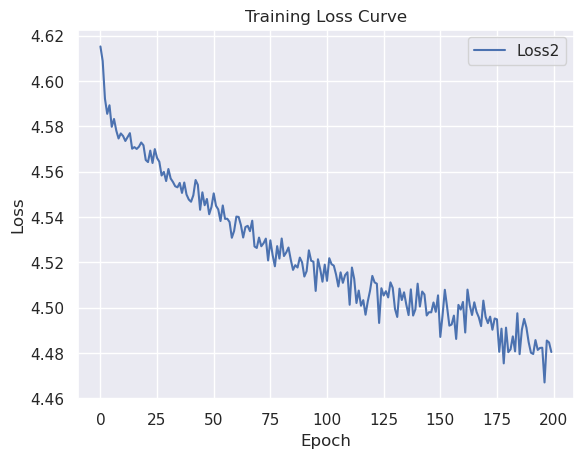

In [62]:
import matplotlib.pyplot as plt
# print(loss_log)
plt.plot(loss2_log, label="Loss2")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.grid(True)
plt.savefig("loss2_curve.png")
plt.show()


In [64]:
print(train_labels.ndim == 2)

False


In [29]:
from tasks import _eval_protocols as eval_protocols
train_repr = model.encode(train_data, encoding_window='full_series' if train_labels.ndim == 1 else None)
test_repr = model.encode(test_data, encoding_window='full_series' if train_labels.ndim == 1 else None)
fit_clf = eval_protocols.fit_svm

In [32]:
clf = fit_clf(train_repr, train_labels)
acc = clf.score(test_repr, test_labels)
y_score = clf.decision_function(test_repr)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import average_precision_score
test_labels_onehot = label_binarize(test_labels, classes=np.arange(train_labels.max()+1))
auprc = average_precision_score(test_labels_onehot, y_score)

In [33]:
print( 'acc:', acc, 'auprc:', auprc )

acc: 0.26666666666666666 auprc: 0.3236681836681837


In [88]:
from tasks.classification import eval_classification
out, eval_res = eval_classification(
                model,
                train_data,
                train_labels,
                test_data,
                test_labels,
                encoding_protocol='full_series',
                eval_protocol='svm'
            )

/opt/conda/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [89]:
print(eval_res)

{'acc': 0.8966666666666666, 'auprc': 0.9398610232588195}


#### **4. Encode representations with the trained model**

When creating the train and test instances of a dataset, there are two methods:
1. The most common for classification and clustering is to separate your train and test datasets by choosing different time series instances. This above means that for a dataset $X \in \mathbb{R}^{B \times T \times F}$, you define $X_{train}$ by slicing X along the instances or batch axis: `X_train = X[:n_train, :, :]`.
2. For forecasting and anomaly detection, another way to build your train and test set is to use all instances up to timestep $T_{train}$ for training, and further timesteps for testing: `X_train = X[:, :T_train, :]`.

If using the first method, please skip to section `4.1`. If using the second method, please read through section `4.0.`

##### **4.0. Using correct test-set time indices**

When splitting your train and test sets along the time axis, it is import to adequately label the timesteps corresponding to the test set: T-Rep uses timesteps to compute time-embeddings, so one shouldn't naively use timesteps $[T_{train}:T_{end}]$, or reindex the test set from timestep 0.

As the model was trained on a previous section of the dataset $X_{train} = [x_{t_0}...x_{T_{train}}]$, with corresponding timesteps $[t_0...T_{train}]$, we will try to find the subsequence of $X_{train}$ which most closely resembles our test set (call that subsequence $[x_{t_a}:x_{t_b}]$, ranging from timesteps $t_a$ to $t_b$). When encoding our test set, we then feed T-Rep $X_{test}$ alongside that subsequence's timesteps $[t_a:t_b]$. This ensures we don't feed out-of-distribution inputs (timesteps) to the time-embedding module.

Finding the closest segment to $X_{test}$ in the train data is very easily done using the `find_closest_train_segment` function, which uses a sliding window and the Euclidean distance.

In [12]:
# closest_time_indices = find_closest_train_segment(
#     train_data,
#     test_data,
#     squared_dist=True
# )
# closest_time_indices.shape

##### **4.1. Encoding representations for forecasting and anomaly detection**

Encode representations at a timestep granularity (one representation vector per timestep), preserving the original data's temporality. This is typically what you might use for **forecasting** or **anomaly detection**.

In [14]:
test_repr_fine = model.encode(
    data=test_data,
    encoding_window=None,
    causal=True,
    sliding_length=1,
    sliding_padding=100,
    batch_size=16
)
print(f"Fine-grained (timestep-wise) representation shape: {test_repr_fine.shape}")

Fine-grained (timestep-wise) representation shape: (1, 2880, 256)


In [19]:
print(test_data.shape)

(1, 2880, 7)


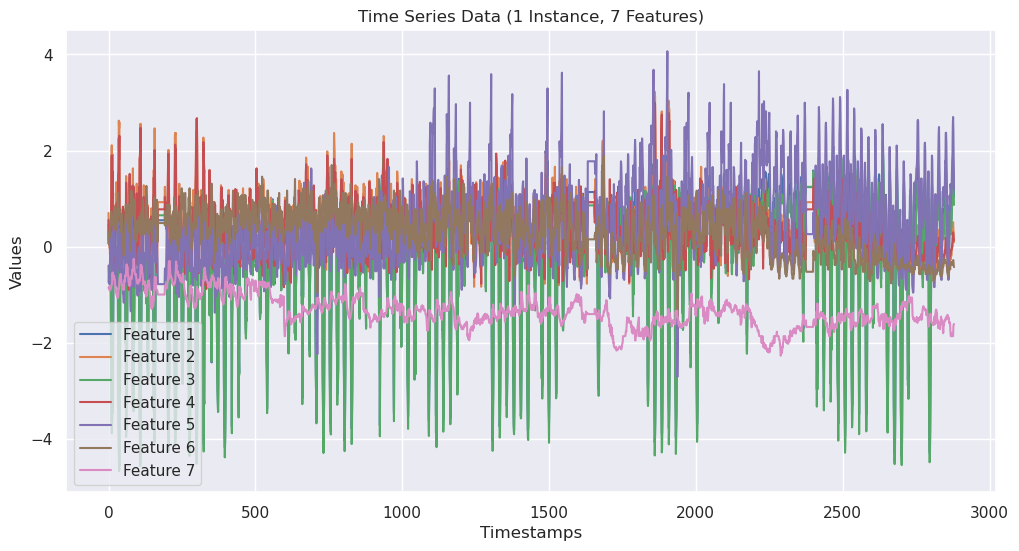

In [20]:
import matplotlib.pyplot as plt
import numpy as np

n_samples, n_timpoints, n_features = test_data.shape
# Plot all features
plt.figure(figsize=(12, 6))
for i in range(n_features):
    plt.plot(test_data[0, :, i], label=f'Feature {i+1}')

plt.xlabel("Timestamps")
plt.ylabel("Values")
plt.title("Time Series Data (1 Instance, 7 Features)")
plt.legend()
plt.show()


##### **4.2. Encoding representations for classification and clustering**

Encode representations at an instance granularity (one representation vector per time-series instance), eliminating the temporal dimension of the data. This is more typically used for **classification** or **clustering**. For these tasks, we often discard the temporal dimension as we care more about **inter-instance** differences than **intra-instance** differences. In most cases, reducing each instance to one representation vector is enough, and helps reduce the intrinsic dimensionality of our problem.

To encode representations at an instance granularity, simply set `encoding_window='full_series'`, which will apply a maxpool operation to the temporal dimension of the representation with a kernel size equal to the length of the time series, resulting in a temporal dimension of 1. You thus obtain one representation vector for entire time series instance.

In [16]:
test_repr_coarse = model.encode(
    data=test_data,
    encoding_window='full_series', # Used to control the temporal granularity of the representation
    causal=False, # Whether to use causal convolutions (for forecasting for instance) or not.
    sliding_length=None, # The length of sliding window. When this param is specified, a sliding inference would be applied on the time series.
    sliding_padding=0, # Contextual data length used for inference every sliding windows.
    batch_size=16
)
print(f"Instance-wide representation shape: {test_repr_coarse.shape}")

Instance-wide representation shape: (1, 256)


##### **4.3. Encoding representations with custom temporal granularity**

Encode representations at a custom temporal granularity, by setting the ``encoding_window`` parameter to an integer. This integer specifies the kernel size that will be used to apply a **maxpool** operation to the timestep-level representation. This may be desirable for more advanced use cases in classification, clustering, anomaly detection, forecasting, or any other downstream tasks.

This works by first computing the representation at full temporal granularity, i.e. with the same number of timesteps as the original data. A maxpool operation is then applied to the temporal dimension of the representation, with kernel size controled by the `encoding_window` parameter of the encoding function. The `stride` and `padding` are both set to `encoding_window // 2`. The representation's temporal dimensionality can be pre-determiend using the usual maxpool dimension formula.

In [ ]:
test_repr_custom = model.encode(
    data=test_data,
    time_indices=closest_time_indices,
    mask=None, # Used for the Anomaly Detection protocol, can be ignored
    encoding_window=50, # Used to control the temporal granularity of the representation
    causal=False, # Whether to use causal convolutions (for forecasting for instance) or not.
    sliding_length=None, # The length of sliding window. When this param is specified, a sliding inference would be applied on the time series.
    sliding_padding=0, # Contextual data length used for inference every sliding windows.
    batch_size=16,
    return_time_embeddings=False
)
print(f"Custom temporal resolution representation shape: {test_repr_custom.shape}")

Custom temporal resolution representation shape: (1, 115, 128)


A special value can be passed to the ``encoding_window`` parameter of the encoding function: it can be set to 'multiscale'. This will concatenate representations at multiple temporal granularities, resulting in a representation which incorporates both global and local information at every timestep. Essentially this results in a larger representation dimensionality, but no temporal resolution change.

In [ ]:
test_repr_multiscale = model.encode(
    data=test_data,
    time_indices=closest_time_indices,
    mask=None, # Used for the Anomaly Detection protocol, can be ignored
    encoding_window='multiscale', # Used to control the temporal granularity of the representation
    causal=False, # Whether to use causal convolutions (for forecasting for instance) or not.
    sliding_length=1, # The length of sliding window. When this param is specified, a sliding inference would be applied on the time series.
    sliding_padding=100, # Contextual data length used for inference every sliding windows.
    batch_size=16,
    return_time_embeddings=False
)
print(f"Multiscale representation shape: {test_repr_multiscale.shape}")

Multiscale representation shape: (1, 2880, 1024)


#### **That's it!**

This is all you need to know to use T-Rep. The produced `np.ndarray` of representations can then be used as inputs for any task ranging from classification, clustering, forecasting, to anomaly detection etc.

### **Forcasting**

Forcasting

In [12]:
data, train_slice, valid_slice, test_slice, scaler, pred_lens = datautils.load_forecast_csv("ETTh1")
train_data = data[:, train_slice]
test_data = data[:, test_slice]
print(f"Shapes - train data: {train_data.shape}, test data: {test_data.shape}")
print(pred_lens)

Shapes - train data: (1, 8640, 7), test data: (1, 2880, 7)
[24, 48, 168, 336, 720]


In [16]:
@dataclass
class Args:
    task_weights: dict
    dataset: str = ""
    loader: str = ""
    gpu: int = 0
    static_repr_dims: int = 128
    dynamic_repr_dims: int = 128
    epochs: int = 80

    run_name: str = ""
    batch_size: int = 16
    lr: float = 0.001
    max_train_length = 800
    iters: int = None
    save_every = None
    seed: int = 1234
    max_threads = None
    eval: bool = True
    irregular = 0

    sample_size: int = 50
    window_size: int = 20

In [17]:
args = Args(
    static_repr_dims=128,
    dynamic_repr_dims=128,
    task_weights={
        'local_static_contrast': 0.5,
        'global_vatiant_contrast': 0,
        'dynamic_trend_pred': 0.5,
    },
    eval=False,
    batch_size=16,
)

device = init_dl_program(args.gpu, seed=args.seed, max_threads=args.max_threads)

In [19]:
sns.set_theme()
torch.cuda.empty_cache()
gc.collect()

0

Training

In [ ]:
model = HDST(
    input_dims=train_data.shape[-1],
    device=device,
    task_weights=args.task_weights,
    batch_size=args.batch_size,
    lr=args.lr,
    output_dims1=args.static_repr_dims,
    output_dims2=args.dynamic_repr_dims,
    max_train_length=args.max_train_length
)

loss_log = model.fit(
    train_data,
    n_epochs=args.epochs,
    n_iters=args.iters,
    k=args.sample_size,
    w=args.window_size
)

In [21]:
from tasks.forecasting import eval_forecasting
out, eval_res = eval_forecasting(
                model,
                data,
                train_slice,
                valid_slice,
                test_slice,
                scaler,
                pred_lens
            )

In [15]:
print(eval_res)

{'ours': {24: {'norm': {'MSE': 0.5345497333310874, 'MAE': 0.4857116184614402}, 'raw': {'MSE': 8.904509991837921, 'MAE': 1.6174581423905672}}, 48: {'norm': {'MSE': 0.5709874766425056, 'MAE': 0.5140474015283316}, 'raw': {'MSE': 9.963386634533675, 'MAE': 1.7547999174515991}}, 168: {'norm': {'MSE': 0.780261750889439, 'MAE': 0.6412761212980428}, 'raw': {'MSE': 12.876545935824426, 'MAE': 2.1548316709321202}}, 336: {'norm': {'MSE': 0.9720049312905923, 'MAE': 0.7451928560347688}, 'raw': {'MSE': 14.30919164227594, 'MAE': 2.399187619420227}}, 720: {'norm': {'MSE': 1.134542634253387, 'MAE': 0.8318223237324436}, 'raw': {'MSE': 15.008771444165824, 'MAE': 2.6278220658417246}}}, 'ts2vec_infer_time': 10.725300312042236, 'lr_train_time': {24: 0.5735461711883545, 48: 0.6071226596832275, 168: 1.7208011150360107, 336: 2.9842255115509033, 720: 5.959838151931763}, 'lr_infer_time': {24: 0.0024785995483398438, 48: 0.003877401351928711, 168: 0.010802268981933594, 336: 0.02632451057434082, 720: 0.04774141311645

In [22]:
print(eval_res)

{'ours': {24: {'norm': {'MSE': 0.6026216915998444, 'MAE': 0.5456942508746859}, 'raw': {'MSE': 10.690880159343335, 'MAE': 1.897547673841865}}, 48: {'norm': {'MSE': 0.6204657892278793, 'MAE': 0.5646989172086511}, 'raw': {'MSE': 13.13848032663061, 'MAE': 2.128377495593315}}, 168: {'norm': {'MSE': 0.8059303267908344, 'MAE': 0.6789866260264988}, 'raw': {'MSE': 18.59880356311113, 'MAE': 2.6630855077497233}}, 336: {'norm': {'MSE': 0.9685650342602257, 'MAE': 0.7708955423797651}, 'raw': {'MSE': 19.387275534175824, 'MAE': 2.86780745940725}}, 720: {'norm': {'MSE': 1.0418977426573888, 'MAE': 0.8174993614359672}, 'raw': {'MSE': 19.712086353572904, 'MAE': 2.9961037358813467}}}, 'ts2vec_infer_time': 10.789113998413086, 'lr_train_time': {24: 0.536553144454956, 48: 0.5942838191986084, 168: 1.6891825199127197, 336: 2.9737794399261475, 720: 5.9565534591674805}, 'lr_infer_time': {24: 0.002521991729736328, 48: 0.004066944122314453, 168: 0.010755538940429688, 336: 0.019112110137939453, 720: 0.04974317550659

### Test global varient loss

I want to test the max_cross_corr function in utils.py

In [ ]:
# import torch
# def max_cross_corr(window1,window2):
#     """
#     Compute the maxmium cross correlation between window1 and window2.
#     """
#     print("window1:",window1.shape)
#     print("window2:",window2.shape)

#     L,C = window1.shape #L: length of window; C: dimension of feature
#     window1 = window1.permute(1, 0).contiguous() # C x L
#     window2 = window2.permute(1, 0).contiguous()
#     window1 = window1 - window1.mean(dim=-1, keepdim=True)
#     window2 = window2 - window2.mean(dim=-1, keepdim=True)

#     window1_fft = torch.fft.rfft(window1, dim=-1)
#     window2_fft = torch.fft.rfft(window2, dim=-1)

#     X = window1_fft * torch.conj(window2_fft)

#     power_norm = (window1.std(dim=-1, keepdim=True) * window2.std(dim=-1, keepdim=True)).to(X.dtype)
#     power_norm = torch.where(power_norm == 0, torch.ones_like(power_norm), power_norm)

#     X = X / power_norm

#     cc = torch.fft.irfft(X, n=L, dim=-1)
#     print("cc:",cc.shape)
#     max_cc = cc.max(dim=-1).values

#     return max_cc
# # Load windows from the .pth file
# window1 = torch.load('window1.pth')
# window2 = torch.load('window2.pth')

# maxcc=max_cross_corr(window1,window2)
# corr=torch.mean(maxcc)
# print(corr)


In [57]:
@dataclass
class Args:
    task_weights: dict
    dataset: str = ""
    loader: str = ""
    gpu: int = 0
    static_repr_dims: int = 128
    dynamic_repr_dims: int = 128
    epochs: int = 80

    run_name: str = ""
    batch_size: int = 16
    lr: float = 0.001
    max_train_length = 800
    iters: int = None
    save_every = None
    seed: int = 1234
    max_threads = None
    eval: bool = True
    irregular = 0

    sample_size: int = 20
    window_size: int = 20

In [63]:
args = Args(
    static_repr_dims=128,
    dynamic_repr_dims=128,
    task_weights={
        'local_static_contrast': 0,
        'global_vatiant_contrast': 1,
        'dynamic_trend_pred': 0,
    },
    eval=False,
    batch_size=64,
)

device = init_dl_program(args.gpu, seed=args.seed, max_threads=args.max_threads)

In [64]:
sns.set_theme()
torch.cuda.empty_cache()
gc.collect()

12689

In [65]:
train_data, train_labels, test_data, test_labels = datautils.load_UEA("ArticularyWordRecognition")
print(f"Shapes - train data: {train_data.shape}, test data: {test_data.shape}")

Shapes - train data: (275, 144, 9), test data: (300, 144, 9)


In [66]:
model = HDST(
    input_dims=train_data.shape[-1],
    device=device,
    task_weights=args.task_weights,
    batch_size=args.batch_size,
    lr=args.lr,
    output_dims1=args.static_repr_dims,
    output_dims2=args.dynamic_repr_dims,
    max_train_length=args.max_train_length
)

loss_log = model.fit(
    train_data,
    n_epochs=args.epochs,
    n_iters=args.iters,
    k=args.sample_size,
    w=args.window_size
)

Training data shape: (275, 144, 9)
Epoch #0: loss=3.6138407588005066
Epoch #1: loss=3.6009421944618225
Epoch #2: loss=3.590627372264862
Epoch #3: loss=3.591188669204712
Epoch #4: loss=3.5748770236968994
Epoch #5: loss=3.5791643857955933
Epoch #6: loss=3.566432237625122
Epoch #7: loss=3.5731990337371826
Epoch #8: loss=3.5748029351234436
Epoch #9: loss=3.5692845582962036
Epoch #10: loss=3.5726457238197327
Epoch #11: loss=3.549648106098175
Epoch #12: loss=3.54321426153183
Epoch #13: loss=3.5594987869262695
Epoch #14: loss=3.554342210292816
Epoch #15: loss=3.5557913184165955
Epoch #16: loss=3.557249963283539
Epoch #17: loss=3.541060984134674
Epoch #18: loss=3.5510867834091187
Epoch #19: loss=3.5513546466827393
Epoch #20: loss=3.541646659374237
Epoch #21: loss=3.5498461723327637
Epoch #22: loss=3.5212833285331726
Epoch #23: loss=3.536434590816498
Epoch #24: loss=3.5406824946403503
Epoch #25: loss=3.5511467456817627
Epoch #26: loss=3.54276305437088
Epoch #27: loss=3.5455803275108337
Epoch #2

In [68]:
from tasks.classification import eval_classification
out, eval_res = eval_classification(
                model,
                train_data,
                train_labels,
                test_data,
                test_labels,
                encoding_protocol='full_series',
                eval_protocol='svm'
            )

/opt/conda/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [69]:
print(eval_res)

{'acc': 0.9633333333333334, 'auprc': 0.9768286487010508}
